In [1]:
import sys, os
PATH = os.path.dirname(os.path.abspath(os.curdir))
if PATH not in sys.path:
    sys.path.insert(0, PATH)

import logging

logging.basicConfig(level=logging.ERROR)
logging.getLogger("torch").setLevel(logging.ERROR)
logging.getLogger("transformers").setLevel(logging.ERROR)

from pathos.multiprocessing import ProcessPool
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import src.Simulator as sim_system
import src.Optimizer as opt
import src.SimGrad as sim_diff
import scipy as sp
import numpy as np
import torch
import tqdm


###* Create Simulator object
reactions_file = "../reactions/reactionsCompleteV2.json"

const_dict = {
        "F0": 1.5e15,           # cm^-2
        "S0": 3e13,             # cm^-2
        
        "R": 0.00831442,        # kJ/mol*K
        "kBoltz": 1.380649e-23, # J/K
}


initial_state_dict = {'O_F': 0.05, 'O2_F':0.05, 'CO_F':0.05, 'CO2_F':0.01, 
                    'O_S': 0.5, 'CO_S':0.1, 'Vdb_S':0.05, 'Odb_S': 0.05,
                    'COdb_S': 0.0}

###* Functions for the data transformation
def compute_flux(const_dict, exp_dict, specie, molar_mass):
    den = exp_dict.get(specie, 0.0)
    v_th = np.sqrt((8.0 * const_dict['R'] * 1000 * exp_dict['Tnw'])/(molar_mass * np.pi))
    flux = 0.25 * v_th * den * 100
    return flux


def compute_remaining_flux(const_dict, exp_dict, molar_mass): 
    den = exp_dict['N'] - exp_dict['O'] - exp_dict['CO']
    v_th = np.sqrt((8.0 * const_dict['R'] * 1000 * exp_dict['Tnw'])/(molar_mass * np.pi))
    flux = 0.25 * v_th * den * 100
    return flux

####? EavgMB data extracted from the Booth et al. 2019 paper
p_data_exp = [0.2, 0.3, 0.4, 0.5, 0.6, 0.75, 1.5]
EavgMB_data = [1.04, 0.91, 0.87, 0.83, 0.77, 0.5, 0.001]
interpolator = sp.interpolate.interp1d(p_data_exp, EavgMB_data, kind='linear', fill_value=0.001, bounds_error=False)


transformations_exp = {
    'Tw':       lambda const_dict, exp_dict: exp_dict['Tw'] + 273.15,
    'fluxO' :   lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O', 0.016),
    'fluxO2' :  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O2', 0.032),
    'fluxO3' :  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O3', 0.048),
    'fluxC':    lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'C', 0.012),
    'fluxCO':   lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'CO', 0.028),
    'fluxCO2':  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'CO2', 0.048),
    'EavgMB':   lambda const_dict, exp_dict: interpolator(exp_dict['pressure']).item(),
    'Ion':      lambda const_dict, exp_dict: 1e14 * exp_dict["current"]
}

output_folder_path = "../Buffer_Data"
exp_data_file = "Experimental_data_CO_Jorge.hdf5"
exp_file = os.path.join(output_folder_path, exp_data_file)

sim = sim_system.Simulator(reactions_file, const_dict, exp_file, initial_state_dict, transformations_exp=transformations_exp)


  d[CO2_F]/dt = -CO2_F*r_29 + r_28*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[CO_F]/dt = -CO_F*O_F*r_35 - 0.02*CO_F*O_S*r_40 - 0.02*CO_F*Odb_S*r_61 - 0.02*CO_F*Vdb_S*r_60 - CO_F*r_31 - CO_F*r_33 - 0.02*CO_F*r_36*(-CO_S - COdb_S - O_S - Odb_S - Vdb_S + 1.0) + r_30*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[CO_S]/dt = CO_F*r_36*(-CO_S - COdb_S - O_S - Odb_S - Vdb_S + 1.0) - CO_S*O_F*r_39 - CO_S*r_37 - CO_S*r_43 - CO_S*r_44 - CO_S*r_45 - CO_S*r_46 + r_32*(-CO_S - COdb_S - O_S - Odb_S - Vdb_S + 1.0)
  d[COdb_S]/dt = CO_F*Vdb_S*r_60 - COdb_S*O_F*r_62 - COdb_S*r_54 - COdb_S*r_55 - COdb_S*r_56 - COdb_S*r_57 - COdb_S*r_59 + Vdb_S*r_49
  d[O2_F]/dt = -O2_F*O_F*r_15 - O2_F*r_10 - O2_F*r_12 - O2_F*r_14 + r_9*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[O_F]/dt = -CO_F*O_F*r_35 - 0.02*CO_S*O_F*r_39 - 0.02*COdb_S*O_F*r_62 - O2_F*O_F*r_15 - 2*O_F**2*r_8 - 0.02*O_F*O_S*r_7 - 0.02*O_F*Odb_S*r_27 - 0.02*O_F*Vdb_S*r_26 - O_F*r_11 - O_F*r_2 - O_F*r_34 - O_F*r_4 - 0.02*O_F*r_5*(-CO_S - COdb_S - O_S - Odb_S - Vdb_S + 1.

In [2]:
###* Create optimization and diff objects with the proper bounds
lower_bounds = np.array([1e-8, 1e-8, 0.0, 1e-8, 1e-8,0.0,1e-8, 1e-8, 0.0,\
                    1e-5, 1e-5, 1e-5, 1e-5, 1e-5, \
                    1e-5, 1e-5, 1e-5, 1e-5, 1e-5
                    ])

upper_bounds = np.array([5e-1, 1e-2, 30.0,5e-1, 1e-2, 30.0,5e-1, 1e-2, 30.0, \
                    1.0, 1.0, 1.0, 1.0, 1.0, \
                    1.0, 1.0, 1.0, 1.0, 1.0
                    ])

##! define parameters to optimize
def func_optimization(params, flag='numpy'):
    
    A_d0, B_d0, E_d0, A_d1, B_d1, E_d1, A_d2, B_d2, E_d2, SF_1, SF_2, SF_3, SF_4, SF_5, SF_6, SF_7, SF_8, SF_9, SF_10 = params
    
    A_d0 = lower_bounds[0] + (upper_bounds[0] - lower_bounds[0]) * A_d0
    B_d0 = lower_bounds[1] + (upper_bounds[1] - lower_bounds[1]) * B_d0
    E_d0 = lower_bounds[2] + (upper_bounds[2] - lower_bounds[2]) * E_d0
    
    A_d1 = lower_bounds[3] + (upper_bounds[3] - lower_bounds[3]) * A_d1
    B_d1 = lower_bounds[4] + (upper_bounds[4] - lower_bounds[4]) * B_d1
    E_d1 = lower_bounds[5] + (upper_bounds[5] - lower_bounds[5]) * E_d1

    A_d2 = lower_bounds[6] + (upper_bounds[6] - lower_bounds[6]) * A_d2
    B_d2 = lower_bounds[7] + (upper_bounds[7] - lower_bounds[7]) * B_d2
    E_d2 = lower_bounds[8] + (upper_bounds[8] - lower_bounds[8]) * E_d2
    
    SF_1 = lower_bounds[9] + (upper_bounds[9] - lower_bounds[9]) * SF_1
    SF_2 = lower_bounds[10] + (upper_bounds[10] - lower_bounds[10]) * SF_2
    SF_3 = lower_bounds[11] + (upper_bounds[11] - lower_bounds[11]) * SF_3
    SF_4 = lower_bounds[12] + (upper_bounds[12] - lower_bounds[12]) * SF_4
    SF_5 = lower_bounds[13] + (upper_bounds[13] - lower_bounds[13]) * SF_5
    
    SF_6 = lower_bounds[14] + (upper_bounds[14] - lower_bounds[14]) * SF_6
    SF_7 = lower_bounds[15] + (upper_bounds[15] - lower_bounds[15]) * SF_7
    SF_8 = lower_bounds[16] + (upper_bounds[16] - lower_bounds[16]) * SF_8
    SF_9 = lower_bounds[17] + (upper_bounds[17] - lower_bounds[17]) * SF_9
    SF_10 = lower_bounds[18] + (upper_bounds[18] - lower_bounds[18]) * SF_10
    
    if flag=='numpy':
        nu_d_mod0 = lambda T: 1e15 * (A_d0 + B_d0 * np.exp(E_d0/(const_dict['R'] * T)))
        nu_d_mod1 = lambda T: 1e15 * (A_d1 + B_d1 * np.exp(E_d1/(const_dict['R'] * T)))
        nu_d_mod2 = lambda T: 1e15 * (A_d2 + B_d2 * np.exp(E_d2/(const_dict['R'] * T)))
    elif flag=='torch':
        nu_d_mod0 = lambda T: 1e15 * (A_d0 + B_d0 * torch.exp(E_d0/(const_dict['R'] * T)))
        nu_d_mod1 = lambda T: 1e15 * (A_d1 + B_d1 * torch.exp(E_d1/(const_dict['R'] * T)))
        nu_d_mod2 = lambda T: 1e15 * (A_d2 + B_d2 * torch.exp(E_d2/(const_dict['R'] * T)))
    else:
        raise ValueError(f"{flag} does not exist")
    
    dict_mod_vec = [
    {"id": 2, "rate": None, "model_dict": {"nu_d": nu_d_mod0}},
    {"id": 10, "rate": None, "model_dict": {"nu_d": nu_d_mod1}},
    {"id": 31, "rate": None, "model_dict": {"SF": SF_2, "nu_d": nu_d_mod2}},
    
    {"id": 30, "rate": None, "model_dict": {"SF": SF_1}},
    {"id": 32, "rate": None, "model_dict": {"SF": SF_3}},
    {"id": 33, "rate": None, "model_dict": {"SF": SF_4}},
    {"id": 34, "rate": None, "model_dict": {"SF": SF_5}},
    
    {"id": 35, "rate": None, "model_dict": {"SF": SF_6}},
    {"id": 36, "rate": None, "model_dict": {"SF": SF_7}},
    {"id": 37, "rate": None, "model_dict": {"SF": SF_8}},
    {"id": 38, "rate": None, "model_dict": {"SF": SF_9}},
    {"id": 39, "rate": None, "model_dict": {"SF": SF_10}},
    ]
    
    return dict_mod_vec


def loss_function(exp, teo, flag='numpy'):
    
    func = ((teo-exp)**2)/(exp**2)
    if flag == 'numpy':
        return np.mean(func)
    elif flag == 'torch':
        return torch.mean(func)
    else:
        raise ValueError(f"{flag} does not exist")


optimizer = opt.Optimizer(sim, 
                        lambda params: func_optimization(params, 'numpy'), 
                        lambda exp, teo: loss_function(exp, teo, 'numpy')
                        )


In [3]:


def loss_full(params, opt_object):
    loss_val, frac_solutions_arr, rates_arr, _, gammas_predicted_arr = opt_object.objective_function_diff(params)
    return loss_val, gammas_predicted_arr


def numerical_grads(params_tuple, pbar=None):
    params_default_list = list(params_tuple)
    grads_params = []

    for i in range(len(params_default_list)):
        
        params_plus = params_default_list.copy()
        params_plus[i] += 1e-3 
        loss, gammas_predicted_arr_plus = loss_full(params_plus, optimizer)
        
        params_minus = params_default_list.copy()
        params_minus[i] -= 1e-3 
        loss, gammas_predicted_arr_minus = loss_full(params_minus, optimizer)
        
        grad_gamma = (gammas_predicted_arr_plus - gammas_predicted_arr_minus)/(2e-3)
        grads_params.append(grad_gamma)
        
        if pbar is not None:
            pbar.update(1)
        

    return grads_params



def compute_spaces(params_vec, pbar=None):

    grad_errors = numerical_grads(tuple(params_vec), pbar)
    grad_errors_arr = np.array(grad_errors).T

    eps = 1e-8
    reg = 1e-6

    percent_info = 0.90
    gamma_exp = (sim.gamma_exp_data_arr).reshape(-1, 1)

    grad_errors = grad_errors_arr / (gamma_exp + eps)
    norms = np.linalg.norm(grad_errors, axis=1, keepdims=True) + eps
    G = grad_errors / norms                 
    F  = G.T @ G    
    
    print("F: ", F.shape)

    F_reg = F + reg * np.eye(F.shape[0], dtype=F.dtype)
    eigvals, eigvecs = np.linalg.eigh(F_reg)  # ascending order

    idx = np.argsort(eigvals)[::-1]  # descending order
    eigvals_sorted = eigvals[idx]
    eigvecs_sorted = eigvecs[:, idx]

    total_mass = eigvals_sorted.sum()
    cumulative = np.cumsum(eigvals_sorted)
    k = int((cumulative < percent_info * total_mass).sum()) + 1
    Vs = eigvecs_sorted[:, :k]
    Vl = eigvecs_sorted[:, k:]
    
    return {
        'Vs': Vs,
        'Vl': Vl,
        'eigen_val': eigvals_sorted,
        'k': k
    }



In [4]:


params_default = np.array([0.01634, 1.67e-4, 19.75, 0.01634, 1.67e-4, 19.75,0.01634, 1.67e-4, 19.75, 1.0, 1.0, 1e-2, 1e-1, 1e-1, 1e-2, 1e-1, 1e-1, 1e-1, 1e-1])

n_samples = 30
noise_scale = 0.25

# params_noise = np.random.normal(loc=0, scale=noise_scale, size=(n_samples, params_default.shape[0]))
params_noise = np.random.uniform(0.0, 0.3, size=(n_samples, params_default.shape[0]))

params_mod = params_default.reshape(1, -1) + params_noise * params_default
params_mod_clamped = np.clip(params_mod, lower_bounds.reshape(1,-1), upper_bounds.reshape(1,-1))
params_normalized = (params_mod_clamped - lower_bounds.reshape(1,-1))/(upper_bounds - lower_bounds)

# print(params_mod.shape)

In [5]:


results_F = Parallel(n_jobs=-1, backend="loky")(delayed(compute_spaces)(params) for params in params_normalized)


loss_multicore = Parallel(n_jobs=-1, backend="loky")(delayed(loss_full)(params, optimizer) for params in params_normalized)



F:  (19, 19)
F:  (19, 19)
F:  (19, 19)
F:  (19, 19)
F:  (19, 19)
F:  (19, 19)
F:  (19, 19)
F:  (19, 19)
F:  (19, 19)
F:  (19, 19)


F:  (19, 19)
F:  (19, 19)
F:  (19, 19)
F:  (19, 19)
F:  (19, 19)
F:  (19, 19)
F:  (19, 19)
F:  (19, 19)
F:  (19, 19)
F:  (19, 19)
F:  (19, 19)
F:  (19, 19)
F:  (19, 19)
F:  (19, 19)
F:  (19, 19)
F:  (19, 19)
F:  (19, 19)
F:  (19, 19)
F:  (19, 19)
F:  (19, 19)


In [6]:
print([result['k'] for result in results_F])

[1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1]


[np.float64(0.113780170754677), np.float64(0.7434223384715918), np.float64(0.5065490325505099), np.float64(0.7073967944939211), np.float64(0.7730400417583765), np.float64(0.23347432728599032), np.float64(0.43800089557981886), np.float64(0.07743688977588073), np.float64(0.4948082804162916), np.float64(0.05374574343643667), np.float64(0.5696024248159114), np.float64(0.7720566255321443), np.float64(0.7363745088371307), np.float64(0.2688939285947523), np.float64(0.7548650875221296), np.float64(0.4466652126633669), np.float64(0.08059654357868654), np.float64(0.6158701714438115), np.float64(0.6070429834429768), np.float64(0.6861371013091093), np.float64(0.2662597273624558), np.float64(0.748784203946572), np.float64(0.7716989667882681), np.float64(0.17655912095942755), np.float64(0.47951850242723704), np.float64(0.7761018567591549), np.float64(0.7530838107319585), np.float64(0.08486809723509997), np.float64(0.7227777724876636), np.float64(0.3144111197950364)]
0.9938899973266256
0.919890247143

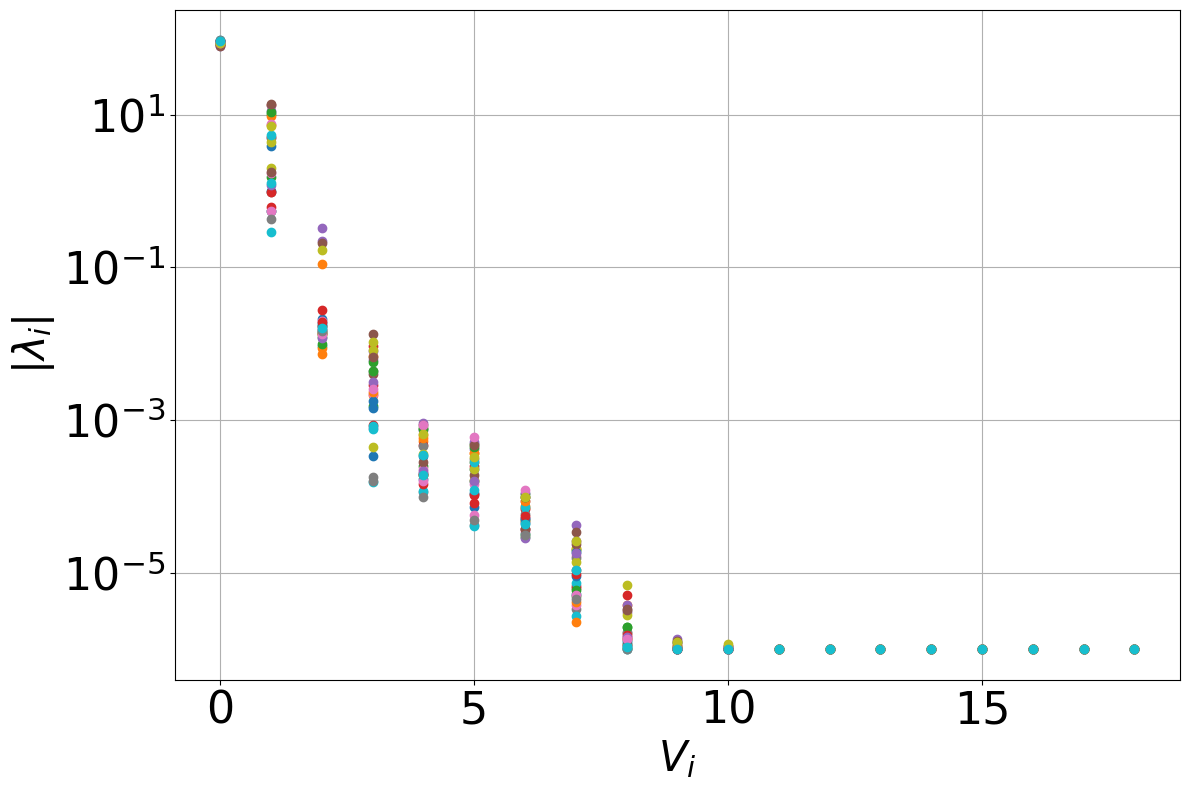

In [7]:

loss_params = [loss_aux[0] for loss_aux in loss_multicore]
print(loss_params)


fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

for config in results_F:
    plt.plot(config['eigen_val'], 'o')
    print(config['eigen_val'][0]/np.sum(config['eigen_val']))
    
    
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)
plt.xlabel(r'$V_i$', fontsize=30)
plt.ylabel(r'$|\lambda_i|$', fontsize=30)
plt.yscale('log')
plt.grid()
plt.tight_layout()
# plt.savefig(f'EigenVals_{n_samples}_noise_{noise_scale}.png')

In [8]:

### statistics of the loss

loss_params_arr = np.array(loss_params)
loss_params_mod_arr = loss_params_arr[loss_params_arr < 1e4]

print(np.mean(loss_params_mod_arr))
print(np.std(loss_params_mod_arr))
print(np.max(loss_params_mod_arr))
print(np.min(loss_params_mod_arr))
print(np.median(loss_params_mod_arr))
print(len(loss_params_mod_arr))

0.49246074269187956
0.25562850889419686
0.7761018567591549
0.05374574343643667
0.5380757286832106
30


In [9]:

angles_stiff = np.zeros((n_samples, n_samples))

for i in range(n_samples):
    for j in range(n_samples):
        if j > i:
            Vs_1 = results_F[i]['Vs'][:,:1]
            Vs_2 = results_F[j]['Vs'][:,:1]
            
            dot_prod = np.abs(np.dot(Vs_1.T, Vs_2).squeeze())
            angles_stiff[i,j] = np.degrees(np.arccos(dot_prod))
            

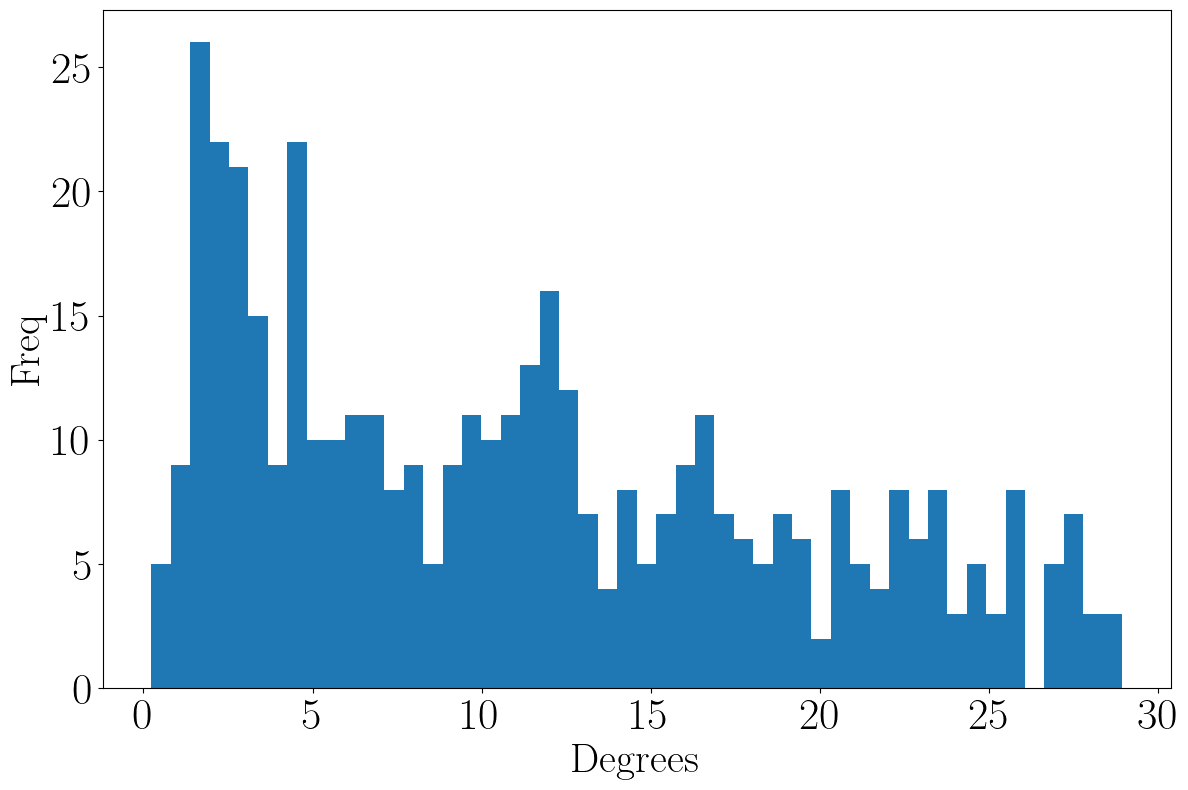

In [10]:

fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

angles_stiff_pos = angles_stiff[angles_stiff > 1e-4]

plt.hist(angles_stiff_pos, bins=50)
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)
plt.xlabel('Degrees', fontsize=30)
plt.ylabel('Freq', fontsize=30)
plt.tight_layout()
# plt.savefig(f'hist_{n_samples}_samples_noise_{noise_scale}.png')